In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve

# Import Data

In [5]:
df = pd.read_csv('Cleaned_Data2.csv')

In [6]:
# def get_installment_and_terms(row):
#     return int(row['term'][:3])*row['installment']
# def get_returns(row):
#     return round(row['loan_amnt']*((1+((row['int_rate']/100)/12))**(int(row['term'][:3])/2)),2)
# def get_annualized_returns(row):
#     return row['returns']-row['loan_amnt']

In [7]:
# #create the return variables based on above definitions
# df['returns'] = df.apply (lambda row: get_returns(row), axis=1)
# df['installments_and_terms'] = df.apply (lambda row: get_installment_and_terms(row), axis=1)
# df['annualized_returns'] = df.apply (lambda row: get_annualized_returns(row), axis=1)

# Data Adjustment

In [8]:
#change the 'object' categories to 'category'
df2 = df.select_dtypes(include='object')
categorical_features = list(df2.columns)
for col in categorical_features:
    df[col] = df[col].astype('category')

In [9]:
#remove the former 'id' column
df = df.drop('Unnamed: 0', axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 872097 entries, 0 to 872096
Data columns (total 65 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   mths_since_recent_inq       872097 non-null  float64 
 1   emp_length                  872097 non-null  category
 2   num_tl_120dpd_2m            872097 non-null  float64 
 3   mo_sin_old_il_acct          872097 non-null  float64 
 4   percent_bc_gt_75            872097 non-null  float64 
 5   mths_since_recent_bc        872097 non-null  float64 
 6   revol_util                  872097 non-null  float64 
 7   dti                         872097 non-null  float64 
 8   debt_settlement_flag        872097 non-null  category
 9   disbursement_method         872097 non-null  category
 10  total_bc_limit              872097 non-null  float64 
 11  total_bal_ex_mort           872097 non-null  float64 
 12  tax_liens                   872097 non-null  float64 
 13 

In [11]:
df.loan_status.value_counts()

Fully Paid     693097
Charged Off    179000
Name: loan_status, dtype: int64

In [12]:
numeric_features = df.select_dtypes(include=['int64', 'float64']).drop(['returns', 'installments_and_terms', 'annualized_returns'], axis=1).columns
categorical_features = df.select_dtypes(include=['category']).drop(['loan_status'], axis=1).columns

print(numeric_features)
print(categorical_features)

Index(['mths_since_recent_inq', 'num_tl_120dpd_2m', 'mo_sin_old_il_acct',
       'percent_bc_gt_75', 'mths_since_recent_bc', 'revol_util', 'dti',
       'total_bc_limit', 'total_bal_ex_mort', 'tax_liens',
       'pub_rec_bankruptcies', 'num_tl_90g_dpd_24m', 'num_tl_30dpd',
       'num_rev_tl_bal_gt_0', 'total_rec_late_fee', 'num_il_tl',
       'num_accts_ever_120_pd', 'tot_coll_amt', 'acc_now_delinq',
       'num_bc_sats', 'mo_sin_rcnt_tl', 'mo_sin_rcnt_rev_tl_op',
       'mo_sin_old_rev_tl_op', 'delinq_amnt', 'chargeoff_within_12_mths',
       'acc_open_past_24mths', 'mort_acc', 'policy_code',
       'collections_12_mths_ex_med', 'last_fico_range_high',
       'collection_recovery_fee', 'num_rev_accts', 'num_tl_op_past_12m',
       'total_rec_int', 'loan_amnt', 'fico_range_high', 'total_acc',
       'revol_bal', 'open_acc', 'pub_rec', 'out_prncp_inv', 'inq_last_6mths',
       'pct_tl_nvr_dlq', 'avg_cur_bal', 'delinq_2yrs', 'int_rate',
       'annual_inc', 'installment', 'libor'],
    

In [13]:
#check for null variables
df.isnull().sum()

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64

In [14]:
#total number of null values
df.isnull().sum().sum()

0

In [15]:
# #this cell takes >10 minutes to run, so can't run this on full data sheet
# #impute numeric values
# imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
# imputer = imputer.fit(df[numeric_features.tolist()])
# df[numeric_features.tolist()] = imputer.transform(df[numeric_features.tolist()])
# #impute categorical values
# imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
# df[categorical_features] = imputerCat.fit_transform(df[categorical_features.tolist()])
# print(df.isnull().sum())

In [16]:
# Create a function we can simply call to generate all the metrics and graph we need
def evaluate_model(predictions, probs, train_predictions, train_probs):
    """Compare machine learning model to baseline performance.
    Computes statistics and shows ROC curve."""
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    results = {}
    results['recall'] = recall_score(y_test, predictions)
    results['precision'] = precision_score(y_test, predictions)
    results['roc'] = roc_auc_score(y_test, probs)
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Test: {round(results[metric], 2)} Train: {round(train_results[metric], 2)}')
    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16
    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'b', label = 'baseline')
    plt.plot(model_fpr, model_tpr, 'r', label = 'model')
    plt.legend();
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curves');

In [21]:
samples = list()
allRows = df.index.values
for i in range(5):
    choices = np.random.choice(allRows, 50000, replace=False)
    samples.append(choices)
    allRows = np.setdiff1d(allRows, choices)

## Sample of 50,000

In [78]:
data = df.copy().iloc[samples[0],:]
data.isnull().sum()

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64

In [28]:
#impute numeric values
imputer = SimpleImputer(missing_values = np.nan, strategy = 'median')
imputer = imputer.fit(data[numeric_features.tolist()])
data[numeric_features.tolist()] = imputer.transform(data[numeric_features.tolist()])

#impute categorical values
imputerCat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
data[categorical_features] = imputerCat.fit_transform(data[categorical_features.tolist()])

print(data.isnull().sum())

mths_since_recent_inq     0
emp_length                0
num_tl_120dpd_2m          0
mo_sin_old_il_acct        0
percent_bc_gt_75          0
                         ..
installment               0
libor                     0
returns                   0
installments_and_terms    0
annualized_returns        0
Length: 65, dtype: int64


# AdaBoost Classifier (for Loan Default)

In [79]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.loan_status

#used to get dummy variables
X = pd.get_dummies(X)
repmap={"Fully Paid": 1, "Charged Off": 0}
y.replace(repmap, inplace=True)

In [80]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 1)

#remove random state eventually

In [81]:
dt = DecisionTreeClassifier(
    max_depth=1 
    , criterion='gini' 
    , min_samples_leaf = 10 
    , splitter = 'random'
#     , random_state=42
)

adb_clf = AdaBoostClassifier(base_estimator=dt, n_estimators=25)
adb_clf.fit(X_train, y_train)

# Predict the test data
y_pred = adb_clf.predict(X_test)

0.9478
              precision    recall  f1-score   support

           0       0.89      0.85      0.87      2056
           1       0.96      0.97      0.97      7944

    accuracy                           0.95     10000
   macro avg       0.93      0.91      0.92     10000
weighted avg       0.95      0.95      0.95     10000



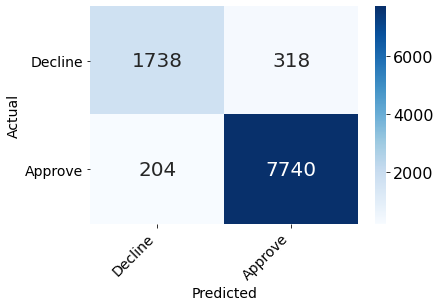

In [82]:
#accuracy score
print(accuracy_score(y_test, y_pred))

#confusion matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Decline', 'Approve'), ('Decline', 'Approve'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)

#precision, recall and f1-score
print(classification_report(y_test, y_pred))

Recall Test: 0.97 Train: 0.97
Precision Test: 0.96 Train: 0.96
Roc Test: 0.98 Train: 0.98


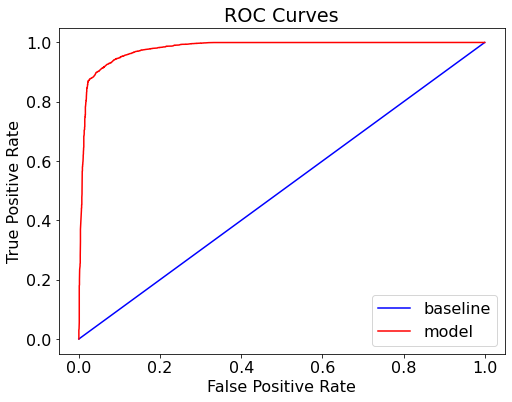

In [83]:
# Evaluating model performance unsing AUC
train_probs = adb_clf.predict_proba(X_train)[:, 1]
probs = adb_clf.predict_proba(X_test)[:, 1]
train_predictions = adb_clf.predict(X_train)
predictions = adb_clf.predict(X_test)
ada_AUC=roc_auc_score(y_test, probs)

evaluate_model(predictions, probs, train_predictions, train_probs)

# Stochastic Gradient Boosting (for Annualized Returns)

In [18]:
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns'])

X = data.loc[:, xVar]
y = data.annualized_returns

#used to get dummy variables
X = pd.get_dummies(X)

In [19]:
#train/test split cell
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

#remove random state eventually

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=100
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 1591.89


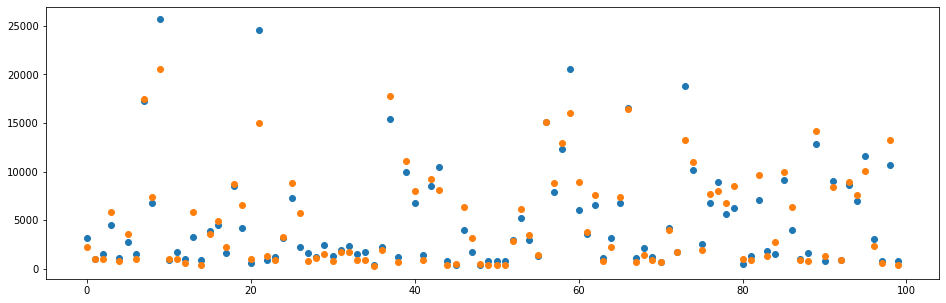

In [21]:
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
# y_test.values.tolist()

plt.scatter(x, y_test[:limit])
plt.scatter(x, y_pred[:limit])

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

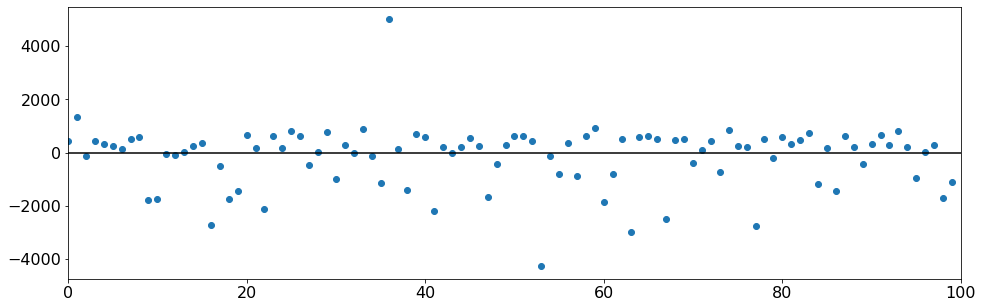

In [175]:
#showing the difference plotted instead of each variable
limit = 100 #max = 10000

x = np.arange(len(y_test))[:limit]
y_plot = y_test-y_pred
# print(np.mean(y_plot))

plt.scatter(x, y_plot[:limit])
plt.hlines(0, xmin=0, xmax=limit)

plt.xlim(0,limit)

fig = plt.gcf()
fig.set_size_inches(16,5)

plt.show()

# Modeling with Percent Return

In [55]:
data = df.copy().iloc[samples[1],:]
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [36]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

sgbt = GradientBoostingRegressor(
    max_depth=1
    , subsample=0.33
    , max_features=0.67
    , n_estimators=100
#     , random_state=42
)
sgbt.fit(X_train, y_train)

# Predict the test set labels
y_pred = sgbt.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))

Test set RMSE: 0.26


In [37]:
from sklearn import metrics, model_selection
def evaluate(y_test, y_pred):
    # this block of code returns all the metrics we are interested in 
    mse = metrics.mean_squared_error(y_test, y_pred)
    msa = metrics.mean_absolute_error(y_test, y_pred)
    r2 = metrics.r2_score(y_test, y_pred)

    print("Mean squared error: ", mse)
    print("Mean absolute error: ", msa)
    print("R^2 : ", r2)
    
    # this creates a chart plotting predicted and actual 
    plt.figure(figsize=(12,6))
    plt.scatter(y_test, y_pred)
    plt.xlabel("Percent Return: $y_i$")
    plt.ylabel("Predicted percent return: $\hat{y}_i$")
    plt.title("Percent Return vs Predicted Percent Return: $y_i$ vs $\hat{y}_i$")

Mean squared error:  0.06941670353251114
Mean absolute error:  0.14520499011584495
R^2 :  0.7158305803858119


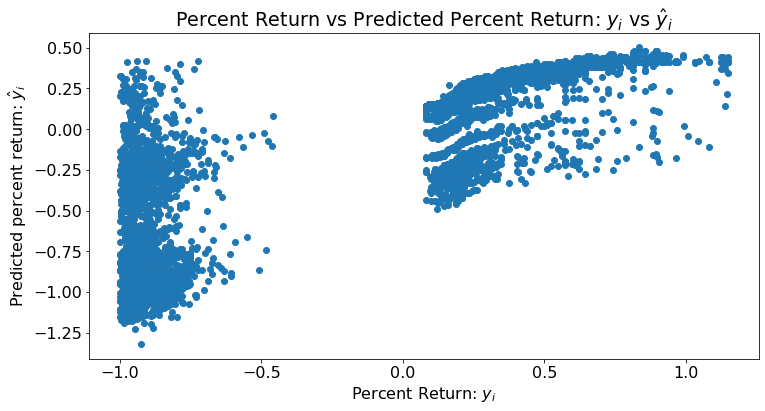

In [38]:
evaluate(y_test,y_pred)

/Users/spencersiegel/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


Mean squared error:  0.06766425509163079
Mean absolute error:  0.14276194042500065
R^2 :  0.7230045346505161
{'max_depth': 1, 'max_features': 0.67, 'n_estimators': 200, 'subsample': 0.33}
0.7238114288335229


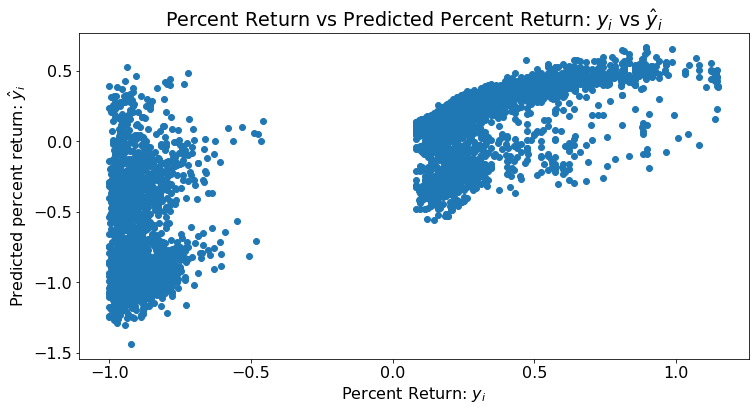

In [39]:
params = {'max_depth':[1], 'subsample':[0.33], 'max_features':[0.5,0.67], 'n_estimators':[100,200]}

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

In [57]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [58]:
import xgboost as xgb
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))


Test set RMSE: 0.22


Mean squared error:  0.049578127526099455
Mean absolute error:  0.10099121658934142
R^2 :  0.7970432618130372


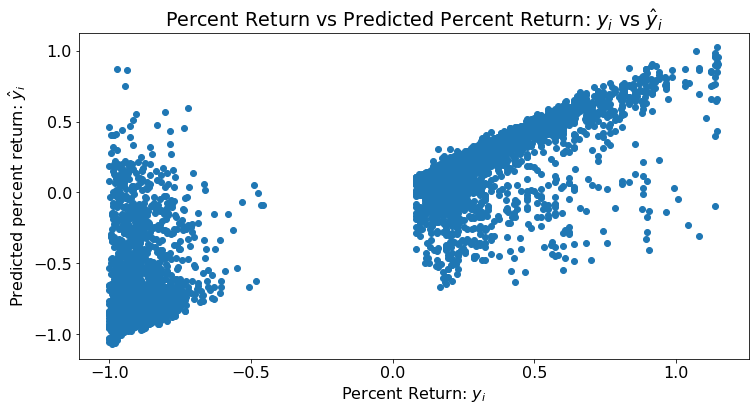

In [59]:
evaluate(y_test,y_pred)

I have not yet done hyperparameter tuning but this is a template. It will take a while to run so we can reduce the number of values we try out

In [43]:
params = {"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ] }

# we then create a grid search object with our chosen model and paramters. 
grid = model_selection.GridSearchCV(sgbt, params, cv=10, iid=False)

# we fit our model to the data as before
grid.fit(X_train, y_train)

# one output of the grid search function is that we can get the best_estimator - the model and parameters that scored best on the training data - 
#  and save it as a new a model
best_model = grid.best_estimator_

# and use it to predict and evaluate as before
y_pred = best_model.predict(X_test)

evaluate(y_test, y_pred)

print(grid.best_params_)
print(grid.best_score_)

ValueError: Invalid parameter colsample_bytree for estimator GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=0.67, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=0.33, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False). Check the list of available parameters with `estimator.get_params().keys()`.

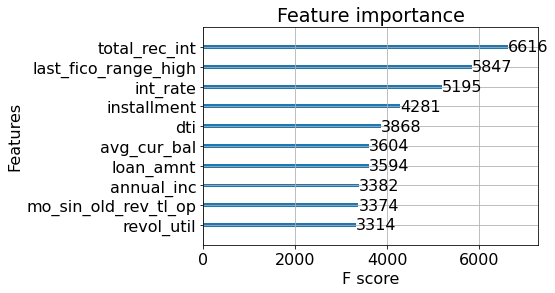

In [60]:
xgb.plot_importance(xg_reg,max_num_features=10)
plt.show()

# Model to Predict Percent Return on Fully Paid Loans

In [61]:
data = df[df['loan_status']=='Fully Paid'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [63]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [64]:
import xgboost as xgb
xg_reg2 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg2.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg2.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))


Test set RMSE: 0.01


Mean squared error:  0.00017909870178638295
Mean absolute error:  0.00802803813985809
R^2 :  0.9933580120297646


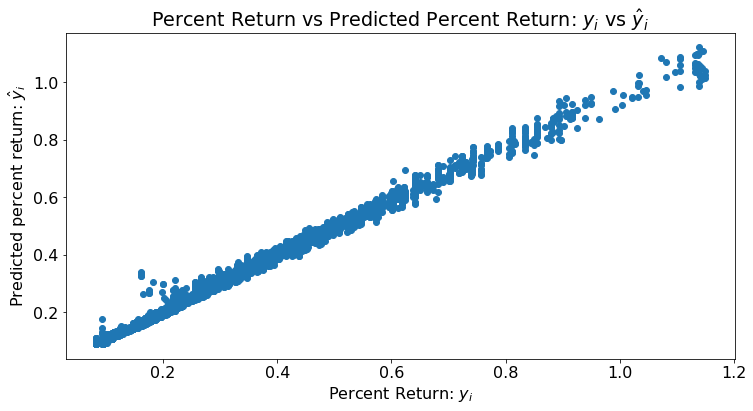

In [65]:
evaluate(y_test,y_pred)

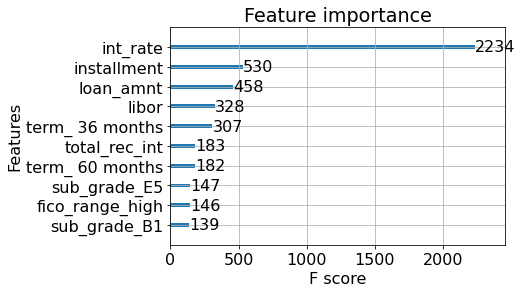

In [66]:
xgb.plot_importance(xg_reg2,max_num_features=10)
plt.show()

# Model to Predict Percent Return on Defaulted Loans

In [67]:
data = df[df['loan_status']=='Charged Off'].sample(50000)
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
y = data.percent_return

#used to get dummy variables
X = pd.get_dummies(X)

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)

In [69]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]
X_test.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test.columns.values]



In [70]:
import xgboost as xgb
xg_reg3 = xgb.XGBRegressor(objective ='reg:squarederror', learning_rate = 0.01,
                max_depth = 10, colsample_bytree=0.5,min_child_weight=3, gamma = 0.2, n_estimators = 500)
xg_reg3.fit(X_train, y_train)

# Predict the test set labels
y_pred = xg_reg3.predict(X_test)

# Evaluate test set RMSE 'rmse_test'
rmse_test = MSE(y_test, y_pred)**(1/2)

# Print 'rmse_test'
print('Test set RMSE: {:.2f}'.format(rmse_test))


Test set RMSE: 0.02


Mean squared error:  0.0005190383456136249
Mean absolute error:  0.01745730666413247
R^2 :  0.9148650678612311


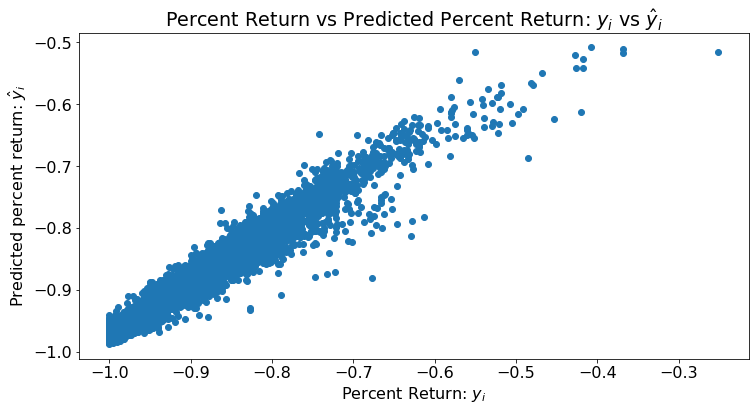

In [71]:
evaluate(y_test,y_pred)

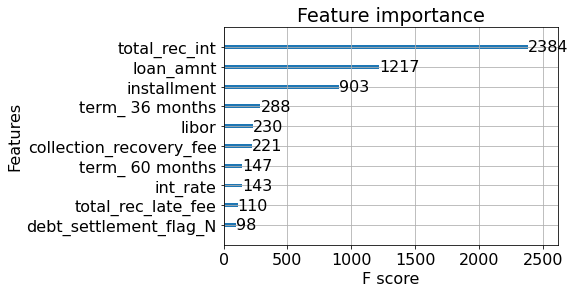

In [72]:
xgb.plot_importance(xg_reg3,max_num_features=10)
plt.show()

# Comparison of 3 Strategies

adb_clf for classifying default

xg_reg for predicting return on all loans

xg_reg2 for predicting return on FP loans, xg_reg3 for predicting return on Defaulted loans

In [119]:
data = pd.concat([df.copy().iloc[samples[2],:],df.copy().iloc[samples[3],:],df.copy().iloc[samples[4],:],])
data['percent_return'] = data['annualized_returns']/data['loan_amnt']
xVar = data.columns
xVar = xVar.drop(['loan_status', 'returns', 'installments_and_terms', 'annualized_returns','percent_return'])
X = data.loc[:, xVar]
X = pd.get_dummies(X)
y = data.percent_return

Method 1: Using the Default Model (Result: ~15% return)

In [130]:
prediction1 = pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid'])
prediction1['percent_return'] = y.values

# These are the loans we pick
prediction1.nlargest(1000,'Fully Paid')

,Default,Fully Paid,percent_return
84182,0.394436,0.605564,0.095727
56930,0.399927,0.600073,0.169258
1975,0.402761,0.597239,0.095726
92836,0.402761,0.597239,0.095726
93324,0.402761,0.597239,0.124364
...,...,...,...
94115,0.424039,0.575961,0.146859
94949,0.424039,0.575961,0.169606
95919,0.424039,0.575961,0.174136
96299,0.424039,0.575961,0.160939


In [121]:
# Percent return by this strategy
np.mean(prediction1.nlargest(1000,'Fully Paid').percent_return)

0.15053510225192732

Method 2: Using the return model (Result: ~95% Return)

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0., 860., 128.,  10.]),
 array([-0.98008611, -0.82961155, -0.67913699, -0.52866242, -0.37818786,
        -0.2277133 , -0.07723874,  0.07323582,  0.22371039,  0.37418495,
         0.52465951]),
 <a list of 10 Patch objects>)

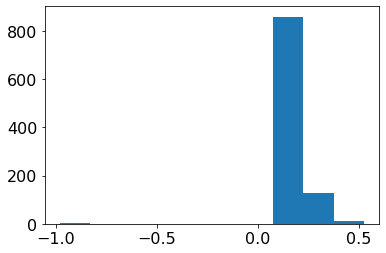

In [153]:
plt.hist(prediction1.nlargest(1000,'Fully Paid')['percent_return'])

In [122]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X.columns.values]


In [123]:
prediction2 = pd.DataFrame(xg_reg.predict(X),columns=['Predicted Return'])
prediction2['Actual Return'] = y.values
# These are the loans we pick
prediction2.nlargest(1000,'Predicted Return')

,Predicted Return,Actual Return
76563,1.048971,1.106283
114020,1.033412,1.138362
11179,1.033390,1.136279
9849,1.024259,1.097056
142653,1.023714,1.106282
...,...,...
129885,0.741257,0.878693
35169,0.741221,0.810918
59770,0.741187,1.143581
109600,0.741164,1.041018


In [124]:
np.mean(prediction2.nlargest(1000,'Predicted Return')['Actual Return'])

0.9539538415395947

(array([  3.,   3.,   0.,   1.,   0.,   0.,   0.,   3., 503., 487.]),
 array([-0.97727509, -0.76466638, -0.55205768, -0.33944897, -0.12684026,
         0.08576845,  0.29837716,  0.51098587,  0.72359458,  0.93620329,
         1.148812  ]),
 <a list of 10 Patch objects>)

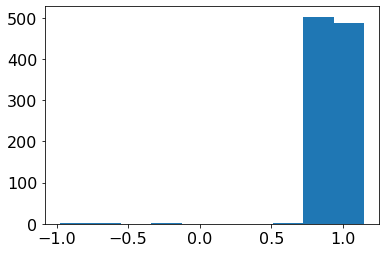

In [141]:
plt.hist(prediction2.nlargest(1000,'Predicted Return')['Actual Return'])

Method 3: Using the Combined Approach (Result: ~83% Return)

In [125]:
prediction3 = pd.concat([pd.DataFrame(adb_clf.predict_proba(X),columns=['Default','Fully Paid']),
           pd.DataFrame(xg_reg2.predict(X),columns=['Fully Paid Predicted Return']),
          pd.DataFrame(xg_reg3.predict(X),columns=['Defaulted Predicted Return'])],axis=1)

In [126]:
prediction3['Expected Return']=prediction3['Default']*prediction3['Defaulted Predicted Return']+prediction3['Fully Paid']*prediction3['Fully Paid Predicted Return']

prediction3['Actual Return'] = y.values

In [127]:
# These are the loans we pick
prediction3.nlargest(1000,'Expected Return')

,Default,Fully Paid,Fully Paid Predicted Return,Defaulted Predicted Return,Expected Return,Actual Return
17598,0.470271,0.529729,1.123164,-0.621168,0.302855,1.148812
86848,0.463339,0.536661,1.079664,-0.603635,0.299725,1.046506
11842,0.460734,0.539266,1.078178,-0.653197,0.280475,1.095522
127146,0.463339,0.536661,1.048672,-0.616764,0.277010,1.046506
121607,0.463339,0.536661,1.085729,-0.662109,0.275887,1.046506
...,...,...,...,...,...,...
79852,0.466157,0.533843,0.895131,-0.810416,0.100078,0.916304
64334,0.471835,0.528165,0.879452,-0.772359,0.100070,0.913494
15319,0.471384,0.528616,1.048904,-0.964095,0.100009,1.140970
148308,0.520323,0.479677,0.933106,-0.668031,0.099998,0.938461


In [128]:
np.mean(prediction3.nlargest(1000,'Expected Return')['Actual Return'])

0.8270145942880132

(array([ 36.,  29.,   7.,   2.,   0.,   0.,   0.,  49., 460., 417.]),
 array([-0.92090143, -0.7139301 , -0.50695876, -0.29998743, -0.0930161 ,
         0.11395524,  0.32092657,  0.5278979 ,  0.73486924,  0.94184057,
         1.1488119 ]),
 <a list of 10 Patch objects>)

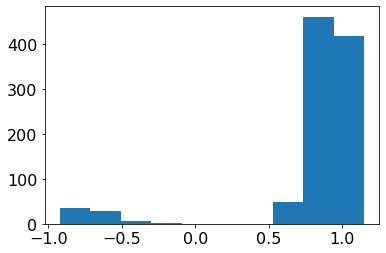

In [136]:
plt.hist(prediction3.nlargest(1000,'Expected Return')['Actual Return'])